# Multiclass classification with CandleGP


GPflow version: *Alexander G. de G. Matthews and James Hensman, 2016*

CandleGP adaptation by *Thomas Viehmann*, 2017

In [1]:
import os,sys
sys.path.append(os.path.join(os.getcwd(),'..'))

import candlegp
import torch
from torch.autograd import Variable
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')
%matplotlib inline

torch.manual_seed(376106123)

## Set up a toy problem

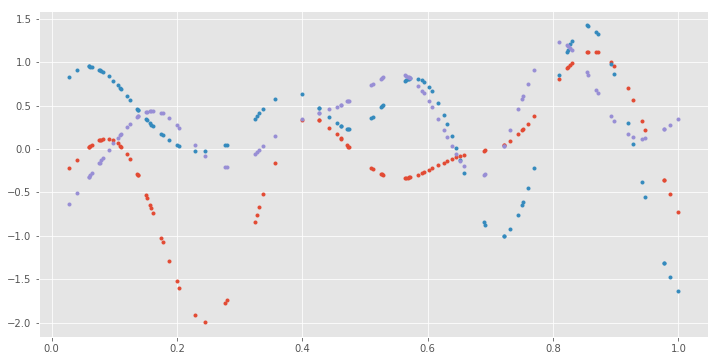

In [2]:
X = torch.rand(100,1,out=torch.DoubleTensor())
K = torch.exp(-0.5*(X - X.t())**2/0.01) + torch.eye(100, out=torch.DoubleTensor())*1e-6
f = torch.matmul(torch.potrf(K, upper=False), torch.randn(100,3,out=torch.DoubleTensor()))

pyplot.figure(figsize=(12,6))
pyplot.plot(X.numpy(), f.numpy(), '.')

In [3]:
Y = torch.max(f,1)[1].unsqueeze(1).double()

## Sparse Variational Gaussian approximation

In [4]:
k_w = candlegp.kernels.White(1, variance=0.01).double()
k = candlegp.kernels.Matern32(1).double() + k_w
m = candlegp.models.SVGP(
    Variable(X), Variable(Y), kern=k,
    likelihood=candlegp.likelihoods.MultiClass(3),
    Z=Variable(X[::5].clone()), num_latent=3, whiten=True, q_diag=True)


In [5]:
k_w.variance.requires_grad = False
m.Z.requires_grad = False


opt = torch.optim.LBFGS([p for p in m.parameters() if p.requires_grad], lr=1e-3, max_iter=40)
def eval_model():
    obj = m()
    opt.zero_grad()
    obj.backward()
    return obj

for i in range(100):
    obj = m()
    opt.zero_grad()
    obj.backward()
    opt.step(eval_model)
    if i%5==0:
        print(i,':',obj.data[0])
m

0 : 506.78550031436197
5 : 372.54828036296436
10 : 261.1034685849412
15 : 174.33948528619817
20 : 157.50763833282826
25 : 148.746362623599
30 : 143.08001554557598
35 : 139.2294275035274
40 : 136.55009017181405
45 : 134.65956783810898
50 : 133.31747038224717
55 : 132.3595924994068
60 : 131.67226080586306
65 : 131.17552254018696
70 : 130.81344187782892
75 : 130.54648637301702
80 : 130.3463743449071
85 : 130.19341375040239
90 : 130.07442285827904
95 : 129.98003275630532


Parameter,Value,Prior,ParamType
Z,[[ 0.32374748] [ 0.46149816] [ 0.47379476] [ 0.65822179] [ 0.46098624] [ 0.51029812] [ 0.57012663] [ 0.75965821] [ 0.42682398] [ 0.19994826] [ 0.64502093] [ 0.6067083 ] [ 0.97717049] [ 0.73198612] [ 0.94152562] [ 0.0620506 ] [ 0.97741616] [ 0.92699862] [ 0.07659158] [ 0.27739153]],None,Param
q_mu,[[-0.86011015 1.69658895 -0.8364788 ] [-0.76912266 -0.64620816 1.41533083] [-0.13355524 -0.58048401 0.71403925] [ 0.89452967 0.21225723 -1.1067869 ] [-0.02723088 0.07244496 -0.04521408] [-0.59176778 -0.22216022 0.813928 ] [-1.07418867 0.74199044 0.33219823] [-1.63833652 -0.16703592 1.80537244] [-0.22609448 1.29056789 -1.06447341] [-1.13015634 -0.88108216 2.0112385 ] [-1.62263989 1.84139982 -0.21875993] [-0.16748159 1.3409163 -1.17343471] [ 0.12749163 -0.84325237 0.71576075] [ 1.64294644 -0.9101985 -0.73274794] [ 1.83337129 0.15050623 -1.98387752] [-0.79778931 2.30210078 -1.50431147] [-0.05661689 -0.00339067 0.06000757] [ 0.11958932 1.06725937 -1.18684868] [-0.3218926 1.15526488 -0.83337228] [-0.03446389 1.42276276 -1.38829887]],None,Param
q_sqrt,[[ 0.66137966 0.3985272 0.43296405] [ 0.53720142 0.20291258 0.20439745] [ 0.67838285 0.37697587 0.39449251] [ 0.11061624 0.11307674 0.22585474] [ 0.99606381 0.95209787 0.95344428] [ 0.74999469 0.32931907 0.32654302] [ 0.5527639 0.21467433 0.21549756] [ 0.24929342 0.39663489 0.23476941] [ 0.85039652 0.45338101 0.46459041] [ 0.58168733 0.28089352 0.28474669] [ 0.48382579 0.49759234 0.75313125] [ 0.92272237 0.72867255 0.75962903] [ 0.22962563 0.42484206 0.24298962] [ 0.37802166 0.73861615 0.38115057] [ 0.40003754 0.45656753 0.57161687] [ 0.66966412 0.45517473 0.49875906] [ 0.99534807 0.99913929 0.99483558] [ 0.59828328 0.65521369 0.74608252] [ 0.83591064 0.58356739 0.59790313] [ 0.88583654 0.72764828 0.7485145 ]],None,PositiveParam
kern.kern_list.0.variance,[ 15.16701361],None,PositiveParam
kern.kern_list.0.lengthscales,[ 0.07947072],None,PositiveParam
kern.kern_list.1.variance,[ 0.01000001],None,PositiveParam


In [6]:
def plot(m):
    f = pyplot.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])
    
    
    xx = Variable(torch.linspace(m.X.data.min(), m.X.data.max(), 200).view(-1,1).double())
    mu, var = m.predict_f(xx)
    mu, var = mu.clone(), var.clone()
    p, _ = m.predict_y(xx)
    
    a3.set_xticks([])
    a3.set_yticks([])
    
    
    a3.set_xticks([])
    
    for i in range(m.likelihood.num_classes):
        x = m.X.data[m.Y.data.view(-1)==i]
        points, = a3.plot(x.numpy(), x.numpy()*0, '.')
        color=points.get_color()
        a1.plot(xx.data.numpy(), mu[:,i].data.numpy(), color=color, lw=2)
        a1.plot(xx.data.numpy(), mu[:,i].data.numpy() + 2*var[:,i].data.numpy()**0.5, '--', color=color)
        a1.plot(xx.data.numpy(), mu[:,i].data.numpy() - 2*var[:,i].data.numpy()**0.5, '--', color=color)
        a2.plot(xx.data.numpy(), p[:,i].data.numpy(), '-', color=color, lw=2)
    
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])

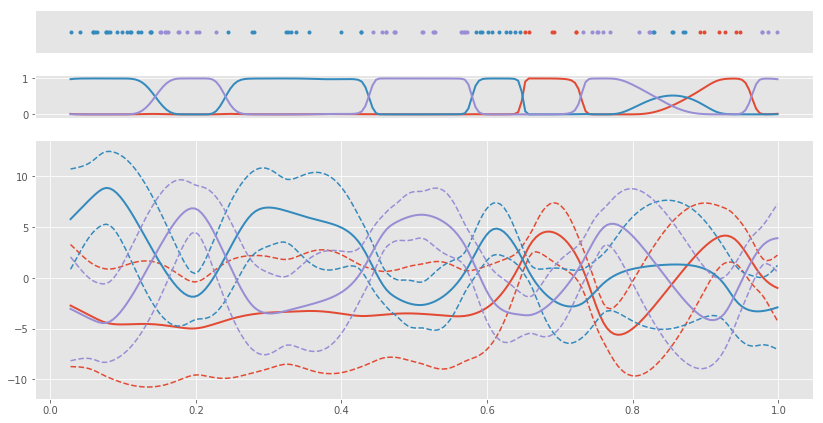

In [7]:
plot(m)

### Sparse MCMC

In [8]:
k_w = candlegp.kernels.White(1, variance=0.01).double()
k_m = candlegp.kernels.Matern32(1, lengthscales=0.1).double()
k = k_m + k_w
m = candlegp.models.SGPMC(Variable(X), Variable(Y), kern=k,
        likelihood=candlegp.likelihoods.MultiClass(3),
        Z=Variable(X[::5].clone()), num_latent=3)
k_m.variance.prior = candlegp.priors.Gamma(1.,1., ttype=torch.DoubleTensor)
k_m.lengthscales.prior = candlegp.priors.Gamma(2.,2., ttype=torch.DoubleTensor)
k_w.variance.requires_grad = False
m.Z.requires_grad = False
m

Parameter,Value,Prior,ParamType
Z,[[ 0.32374748] [ 0.46149816] [ 0.47379476] [ 0.65822179] [ 0.46098624] [ 0.51029812] [ 0.57012663] [ 0.75965821] [ 0.42682398] [ 0.19994826] [ 0.64502093] [ 0.6067083 ] [ 0.97717049] [ 0.73198612] [ 0.94152562] [ 0.0620506 ] [ 0.97741616] [ 0.92699862] [ 0.07659158] [ 0.27739153]],None,Param
V,[[ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.] [ 0. 0. 0.]],"N([ 0.],[ 1.])",Param
kern.kern_list.0.variance,[ 0.99999996],"Ga([ 1.],[ 1.])",PositiveParam
kern.kern_list.0.lengthscales,[ 0.10000005],"Ga([ 2.],[ 2.])",PositiveParam
kern.kern_list.1.variance,[ 0.01000001],None,PositiveParam


In [9]:
opt = torch.optim.LBFGS([p for p in m.parameters() if p.requires_grad], lr=1e-3, max_iter=40)
def eval_model():
    obj = m()
    opt.zero_grad()
    obj.backward()
    return obj

for i in range(100):
    obj = m()
    opt.zero_grad()
    obj.backward()
    opt.step(eval_model)
    if i%5==0:
        print(i,':',obj.data[0])
m

0 : 569.4715344089939
5 : 303.8086204642631
10 : 270.6039258271297
15 : 246.35232391882303
20 : 227.19663362370792
25 : 211.0042576809076
30 : 197.77682013728523
35 : 186.871698932309
40 : 177.79666933559537
45 : 170.30218266534428
50 : 164.03955180743054
55 : 158.04334048758295
60 : 153.65240470329104
65 : 150.2176299906378
70 : 147.4833360805244
75 : 145.3379434104448
80 : 143.6890161030872
85 : 142.4368425927377
90 : 141.49922188509197
95 : 140.8106290595355


Parameter,Value,Prior,ParamType
Z,[[ 0.32374748] [ 0.46149816] [ 0.47379476] [ 0.65822179] [ 0.46098624] [ 0.51029812] [ 0.57012663] [ 0.75965821] [ 0.42682398] [ 0.19994826] [ 0.64502093] [ 0.6067083 ] [ 0.97717049] [ 0.73198612] [ 0.94152562] [ 0.0620506 ] [ 0.97741616] [ 0.92699862] [ 0.07659158] [ 0.27739153]],None,Param
V,[[-0.35890372 0.86843336 -0.50952964] [-0.08709892 -0.6644149 0.75151381] [-0.10721308 -0.17997653 0.28718961] [ 0.48066003 0.25332363 -0.73398366] [ 0.04332082 0.03808724 -0.08140806] [-0.28844555 -0.024923 0.31336854] [-0.61063806 0.56964117 0.0409969 ] [-1.36416046 0.10627009 1.25789037] [ 0.03551734 0.51972862 -0.55524596] [-0.51335363 -0.8487127 1.36206632] [-1.49091722 1.41396499 0.07695224] [-0.22257802 0.74508187 -0.52250385] [ 0.43334438 -0.56976676 0.13642238] [ 1.33040101 -0.68724937 -0.64315164] [ 1.52951647 0.27841304 -1.80792951] [-0.07855935 1.58646243 -1.50790308] [-0.09061092 -0.0256769 0.11628781] [ 0.31619072 0.7976902 -1.11388092] [-0.11393462 0.86792328 -0.75398866] [ 0.11083683 1.3707252 -1.48156203]],"N([ 0.],[ 1.])",Param
kern.kern_list.0.variance,[ 5.26654292],"Ga([ 1.],[ 1.])",PositiveParam
kern.kern_list.0.lengthscales,[ 0.1349979],"Ga([ 2.],[ 2.])",PositiveParam
kern.kern_list.1.variance,[ 0.01000001],None,PositiveParam


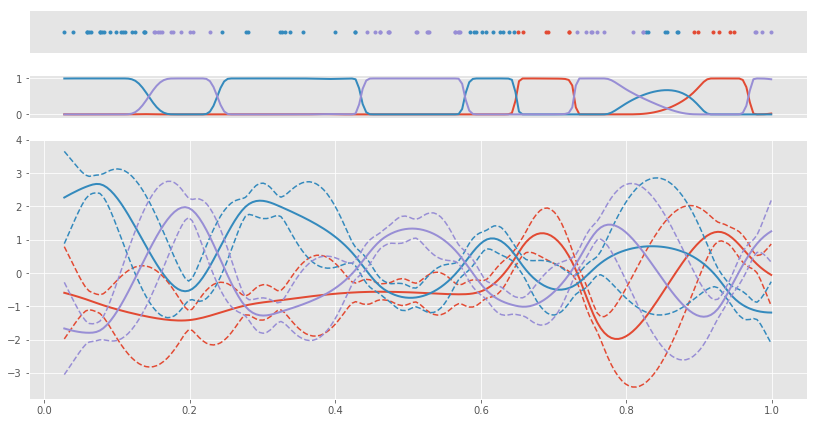

In [10]:
plot(m)

In [11]:
import candlegp.training.hmc
res = candlegp.training.hmc.hmc_sample(m, 50, epsilon=0.04, burn=50, thin=10, lmax=15)


[]

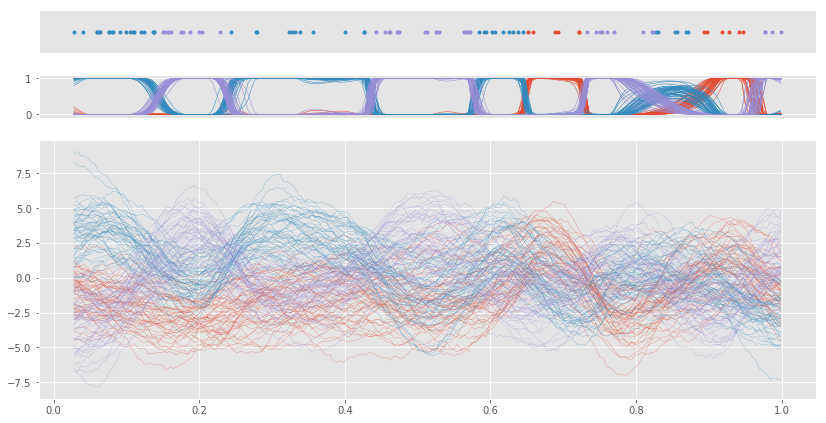

In [12]:
    #def plot_from_samples(m, samples):
    samples = res
    f = pyplot.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])
    
    xx = torch.linspace(m.X.data.min(), m.X.data.max(), 200, out=torch.DoubleTensor()).unsqueeze(1)
    
    Fpred = []
    Ypred = []
    for ps in zip(*res[1:]):
        for mp,p in zip(m.parameters(),ps):
            mp.set(p)
        Ypred.append(m.predict_y(Variable(xx))[0].data)
        Fpred.append(m.predict_f_samples(Variable(xx), 1).squeeze().t().data)
    Fpred = torch.stack(Fpred, dim=0)
    Ypred = torch.stack(Ypred, dim=0)

    for i in range(m.likelihood.num_classes):
        x = m.X.data[m.Y.data == i]
        points, = a3.plot(x.numpy(), torch.zeros_like(x).numpy(), '.')
        color = points.get_color()
        for F in Fpred:
            a1.plot(xx.numpy(), F[:,i].numpy(), color=color, lw=0.2, alpha=1.0)
        for Y in Ypred:
            a2.plot(xx.numpy(), Y[:,i].numpy(), color=color, lw=0.5, alpha=1.0)
    
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])
        
    a3.set_xticks([])
    a3.set_yticks([])
    

    #plot_from_samples(m, res)

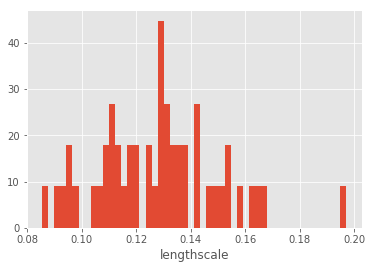

In [13]:
lengthscaleidx = [i for i,(n,_) in enumerate(m.named_parameters()) if n.endswith(".lengthscales")][0]
pyplot.hist(numpy.array(res[1+lengthscaleidx]), normed=True, bins=50)
pyplot.xlabel('lengthscale')